In [1]:
from sympy import false, true
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pickle
import matplotlib.pyplot as plt
import optuna
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

/opt/anaconda3/envs/ep_forecasting_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Data Import 

# Load X_train
with open("data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Load y_train
with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load X_val
with open("data/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

# Load y_val
with open("data/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

# Load X_test
with open("data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y_test
with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Load df_final_viz
with open("data/df_final_viz.pkl", "rb") as f:
    df_final_viz = pickle.load(f)

In [4]:
torch.set_num_threads(torch.get_num_threads())  # Nutzt standardmäßig alle verfügbaren Kerne
print(f"PyTorch nutzt {torch.get_num_threads()} Threads")

PyTorch nutzt 8 Threads


In [5]:
# In Torch-Tensoren umwandeln
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Datasets und DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last = True, num_workers = 8)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last = True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last = True, num_workers = 8)

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hp):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hp['lstm_units'], batch_first=True)
        self.dropout1 = nn.Dropout(hp['dropout_rate_lstm'])
        self.fc1 = nn.Linear(hp['lstm_units'], hp['dense_units'])
        self.dropout3 = nn.Dropout(hp['dropout_rate_dense'])
        self.fc2 = nn.Linear(hp['dense_units'], 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        return out



In [8]:
def objective(trial):
    hp = {
        'lstm_units': trial.suggest_int('lstm_units', 16, 256, step=16),
        'dropout_rate_lstm': trial.suggest_float('dropout_rate_lstm', 0.1, 0.5, step=0.1),
        'dense_units': trial.suggest_int('dense_units', 8, 64, step=8),
        'dropout_rate_dense': trial.suggest_float('dropout_rate_dense', 0.0, 0.4, step=0.1),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4]),
        'weight_decay': trial.suggest_categorical('weight_decay', [1e-5, 1e-4, 1e-3]),
    }

    lstm_model = LSTMModel(input_size=X_train.shape[2], hp=hp)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=hp['learning_rate'], weight_decay=hp['weight_decay'])

    num_epochs = 15
    patience = 7  # Stop, wenn val_loss sich x Epochen lang nicht verbessert
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        lstm_model.train()
        train_loss = 0.0

        # Training Loop
        for X_batch, y_batch in train_loader:
            y_pred = lstm_model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation Loop (nach jeder Epoche)
        lstm_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = lstm_model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0  # Reset Counter
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping nach {epoch+1} Epochen.")
                break

    return best_val_loss  # Val Loss zurückgeben für Optuna

# Hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, n_jobs = 6)

# Show Best Result
print("Best trial parameters:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")


[I 2025-03-31 16:46:45,949] A new study created in memory with name: no-name-f2acdbb8-4965-4fbf-a0ca-0802e2858144
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/ep_forecasting_env/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/ep_forecasting_env/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
      File "/opt/anaconda3/envs/ep_forecasting_env/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/opt/anaconda3/envs/ep_forecasting_env/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
self = reduction.pickle.load(from_parent)
  File "/opt/anaconda3/envs/ep_forecasting_env/lib/python3.9/site-packages/torch/__init__.py", line 2108, in <module>
    exitcode = 

KeyboardInterrupt: 

In [7]:
# save best hyperparameters
best_hp = study.best_trial.params
with open("best_hp_all_models/best_hp_lstm.json", "w") as f:
    json.dump(best_hp, f)

NameError: name 'study' is not defined

In [8]:
# load best hyperparameters
with open("best_hp_all_models/best_hp_lstm.json", "r") as f:
    best_hp = json.load(f)

Epoch [1/50], Train Loss: 0.0095, Val Loss: 0.0020
Epoch [2/50], Train Loss: 0.0024, Val Loss: 0.0015
Epoch [3/50], Train Loss: 0.0018, Val Loss: 0.0010
Epoch [4/50], Train Loss: 0.0016, Val Loss: 0.0010
Epoch [5/50], Train Loss: 0.0014, Val Loss: 0.0007
Epoch [6/50], Train Loss: 0.0013, Val Loss: 0.0007
Epoch [7/50], Train Loss: 0.0012, Val Loss: 0.0007
Epoch [8/50], Train Loss: 0.0012, Val Loss: 0.0006
Epoch [9/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [10/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [11/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [12/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [13/50], Train Loss: 0.0011, Val Loss: 0.0009
Epoch [14/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [15/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [16/50], Train Loss: 0.0010, Val Loss: 0.0007
Epoch [17/50], Train Loss: 0.0010, Val Loss: 0.0006
Epoch [18/50], Train Loss: 0.0010, Val Loss: 0.0006
Epoch [19/50], Train Loss: 0.0010, Val Loss: 0.0005
Epoch [20/50], Train 

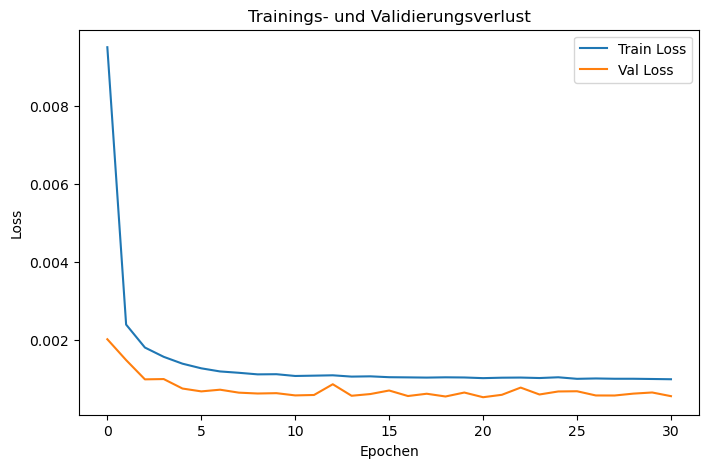

In [9]:
# Bestes Modell mit den gefundenen Hyperparametern trainieren
final_model = LSTMModel(input_size=X_train.shape[2], hp=best_hp)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_hp['learning_rate'], weight_decay=best_hp['weight_decay'])

num_epochs = 50
patience = 10  # Stop, wenn val_loss sich x Epochen lang nicht verbessert
best_val_loss = float('inf')
early_stopping_counter = 0
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    final_model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = final_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)

    # Validation Loss berechnen
    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = final_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset Counter
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping nach {epoch+1} Epochen.")
            break

# Save weights of the model 
torch.save(final_model.state_dict(), "saved_models/lstm_model_final.pth")


# **Trainingshistorie plotten**
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.legend()
plt.title("Trainings- und Validierungsverlust")
plt.show()

In [10]:
# load trained model  
lstm_final = LSTMModel(input_size=X_train.shape[2], hp=best_hp)
lstm_final.load_state_dict(torch.load("saved_models/lstm_model_final.pth"))
lstm_final.eval()

LSTMModel(
  (lstm1): LSTM(17, 64, batch_first=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (dropout3): Dropout(p=0.0, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

                           generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00  

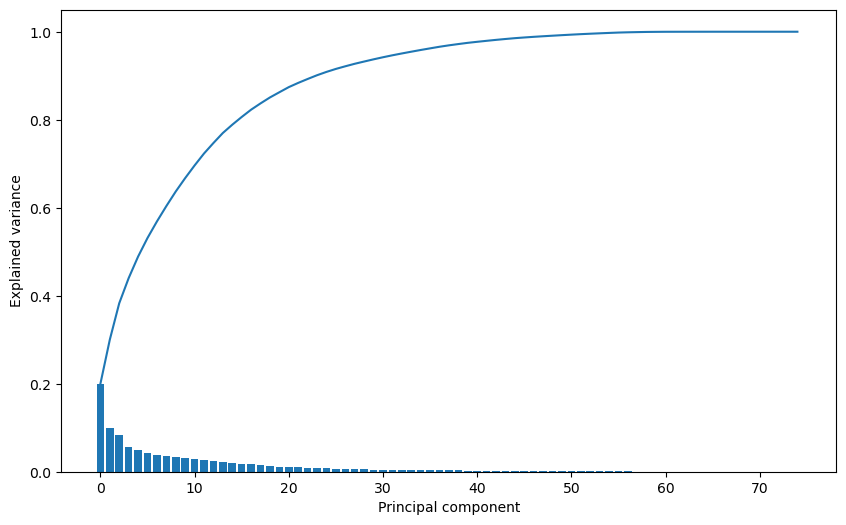

Train MSE: 6.7939, Train RMSE: 2.6065
Validation MSE: 6.3575, Validation RMSE: 2.5214
Test MSE: 7.0361, Test RMSE: 2.6526


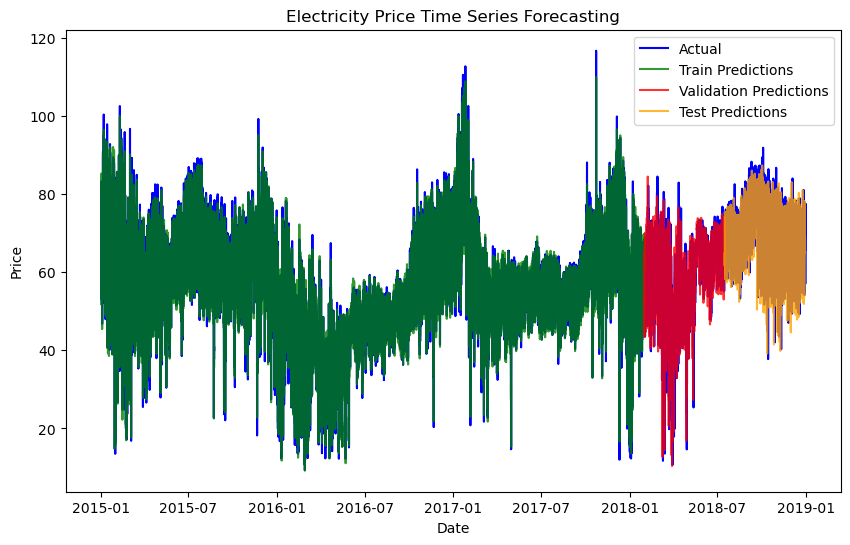

In [11]:
import import_ipynb
from feature_engineering import scaler_y

# Make predictions 
with torch.no_grad():
    train_predictions = lstm_final(X_train_tensor).numpy()
    validation_predictions = lstm_final(X_val_tensor).numpy()
    test_predictions = lstm_final(X_test_tensor).numpy()

# Inverse transform predictions
train_predictions = scaler_y.inverse_transform(train_predictions)
validation_predictions = scaler_y.inverse_transform(validation_predictions)
test_predictions = scaler_y.inverse_transform(test_predictions)

y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_val_actual = scaler_y.inverse_transform(y_val.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate loss
mse_train = mean_squared_error(y_train_actual, train_predictions)
rmse_train = np.sqrt(mse_train)

mse_val = mean_squared_error(y_val_actual, validation_predictions)
rmse_val = np.sqrt(mse_val)

mse_test = mean_squared_error(y_test_actual, test_predictions)
rmse_test = np.sqrt(mse_test)

print(f"Train MSE: {mse_train:.4f}, Train RMSE: {rmse_train:.4f}")
print(f"Validation MSE: {mse_val:.4f}, Validation RMSE: {rmse_val:.4f}")
print(f"Test MSE: {mse_test:.4f}, Test RMSE: {rmse_test:.4f}")

# Plot of the forecast
plt.figure(figsize=(10, 6))

# Plot of actual values
seq_length = 24
plt.plot(df_final_viz.index[seq_length:], df_final_viz['price actual'][seq_length:], label='Actual', color='blue')

# Plot of trainings forecast
plt.plot(df_final_viz.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions', color='green', alpha=0.8)

# Plot of validation forecast
validation_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(validation_predictions))
plt.plot(df_final_viz.index[validation_pred_index], validation_predictions, label='Validation Predictions', color='red', alpha=0.8)

# Plot of test forecast
test_pred_index = range(seq_length+len(train_predictions)+len(validation_predictions), seq_length+len(train_predictions)+len(validation_predictions)+len(test_predictions))
plt.plot(df_final_viz.index[test_pred_index], test_predictions, label='Test Predictions', color='orange', alpha=0.8)

plt.title('Electricity Price Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()